In [138]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt

#Set random_seed for reproducible result
RANDOM_SEED = np.random.seed(0)
#Import our data
df = pd.read_csv('weekly-fuel-prices-in-italy.csv',sep=';')
df

,SURVEY_DATE,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
0,2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
4,2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...,...
5353,2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
5354,2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
5355,2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45
5356,2022-10-31,6,Residual fuel oil,1223.00,111.18,166.84,944.98,-1.91


In [139]:
# Step 1: Data Cleaning
df.dropna(inplace=True)  # remove any rows with missing values
df = df[df['PRICE'] > 0]  # remove any rows with negative or zero prices
df

,SURVEY_DATE,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
0,2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
4,2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...,...
5353,2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
5354,2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
5355,2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45
5356,2022-10-31,6,Residual fuel oil,1223.00,111.18,166.84,944.98,-1.91


In [140]:
# Step 2: Convert the 'date' column to a datetime object and set it as the index
df['SURVEY_DATE'] = pd.to_datetime(df['SURVEY_DATE'])
df.set_index('SURVEY_DATE', inplace=True)
df

,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
SURVEY_DATE,,,,,,,
2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...
2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45


In [141]:
# #Plot the anitial ACF and PACF for each fuel type

# # Pivot the data
# df_pivot = df.pivot_table(index='SURVEY_DATE', columns='PRODUCT_NAME', values='PRICE')

# # Calculate and plot ACF and PACF for each fuel type
# for fuel_type in df_pivot.columns:
#     print(f'ACF and PACF for {fuel_type}:')
#     y = df_pivot[fuel_type].dropna()
    
#     # Calculate ACF and PACF
#     lag_acf = acf(y, nlags=40)
#     lag_pacf = pacf(y, nlags=40, method='ols')

#     # Plot ACF
#     plt.figure(figsize=(12, 6))
#     plt.subplot(121)
#     plot_acf(y, lags=40, ax=plt.gca())
#     plt.title(f'Autocorrelation Function for {fuel_type}')

#     # Plot PACF
#     plt.subplot(122)
#     plot_pacf(y, lags=40, ax=plt.gca())
#     plt.title(f'Partial Autocorrelation Function for {fuel_type}')

#     plt.tight_layout()
#     plt.show()

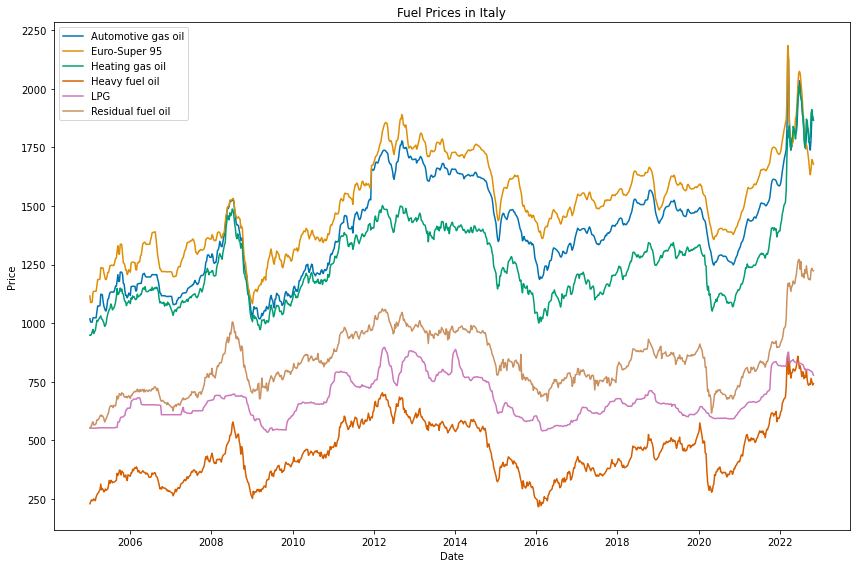

In [142]:
# Define a color palette for each fuel type
colors = sns.color_palette('colorblind', n_colors=len(df_pivot.columns))

# Create a plot for each key in df_pivot
plt.figure(figsize=(12, 8))
for i, key in enumerate(df_pivot):
    plt.plot(df_pivot.index, df_pivot[key], color=colors[i], label=key)
# Add legend and axis labels
plt.legend()

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Fuel Prices in Italy')
plt.tight_layout()
# Show the plot
plt.show()

In [143]:
# #Our AGO price is clearly non statationary as we can se an upward trend in price. The level and
# #Variability both increasing with time hence, we can surely said there is a large seasonal component
# #with period of 12.

# #We then transform the data into a stationary type using multiple methods

# #Method 1: Box-Cox Transformations

# def boxcox_decompose(ts, graph_title=""):
#     decomposition, lam = boxcox(ts) 
#     # Create a stationary time series by obtaining our residuals from classical decompostion
#     stationary_ts = decomposition

#     # Plot the original time series and its components
#     fig, ax = plt.subplots(1, 2)
#     sns.distplot(ts, hist = False, kde = True,
#             kde_kws = {'shade': True, 'linewidth': 2},
#             label = "Before Box-Cox", color ="blue", ax = ax[0])
#     sns.distplot(stationary_ts, hist = False, kde = True,
#             kde_kws = {'shade': True, 'linewidth': 2},
#             label = "After Box-Cox", color ="green", ax = ax[1])
#     fig.legend(loc = "center right")
#     ax[0].set(title="Probability plot before Box-Cox")
#     ax[1].set(title="Probability plot after Box-Cox")
#     fig.set_figheight(5)
#     fig.set_figwidth(10)
    
#     fig, ax = plt.subplots(1, 2)
#     prob = stats.probplot(ts, dist=stats.norm, plot=ax[0])
#     title="At lambda "
#     title+= str(round(lam,3))
#     ax[0].set(title=title)
#     prob = stats.probplot(stationary_ts, dist=stats.norm, plot=ax[1])
#     ax[1].set(title="")

#     fig.set_figheight(5)
#     fig.set_figwidth(17)

#     plt.tight_layout()

#     return stationary_ts

# # Perform classical decomposition and create a stationary time series for each fuel type
# stationary_boxcox_dict = {}
# for fuel_type in df_pivot.columns:
#     #print(f'Box-Cox Decomposition for {fuel_type}:')
#     gtitle = "Box-Cox Decomposition for "
#     gtitle += fuel_type
#     y = df_pivot[fuel_type].dropna()
#     stationary_boxcox_ts = boxcox_decompose(y,gtitle)
#     stationary_boxcox_dict[fuel_type] = stationary_boxcox_ts

In [144]:
# # Plot the original time series Box-Cox time series
    
# for fuel_type in df_pivot.columns:
#     y = df_pivot[fuel_type].dropna()
#     plt.figure(figsize=(12, 8))
#     plt.subplot(411)
#     plt.plot(y, label='Original')
#     plt.title(fuel_type)
#     plt.legend(loc='upper left')
#     plt.subplot(412)
#     plt.plot(stationary_boxcox_dict[fuel_type], label='Stationary Time Series Box-Cox')
#     plt.legend(loc='upper left')
#     plt.tight_layout()
#     # Plot the stationary time series    
#     plt.show()
    

In [145]:
# #Plot the Box-Cox time-series ACF and PACF
# import warnings
# warnings.filterwarnings('ignore')#Supress warning

# for fuel_type in stationary_boxcox_dict:
#     print(f'Box-Cox ACF and PACF for {fuel_type}:')
#     y = stationary_boxcox_dict[fuel_type]
    
#     # Calculate ACF and PACF
#     lag_acf = acf(y, nlags=40), 
#     lag_pacf = pacf(y, nlags=40, method='ols')

#     # Plot ACF
#     plt.figure(figsize=(12, 6))
#     plt.subplot(121)
#     plot_acf(y, lags=40, ax=plt.gca())
#     plt.title(f'Box-Cox Autocorrelation Function for {fuel_type}')

#     # Plot PACF
#     plt.subplot(122)
#     plot_pacf(y, lags=40, ax=plt.gca())
#     plt.title(f'Box-Cox Partial Autocorrelation Function for {fuel_type}')

#     plt.tight_layout()
#     plt.show()

In [146]:
# def classical_decompose(ts, graph_title="",period=52): #Period =52 represents assumption of yearly seasonality
#     # Perform seasonal decomposition
#     decomposition = seasonal_decompose(ts, period=period, model='additive') #Classical decomposition using linear/quadratic

#     # Extract components
#     trend = decomposition.trend
#     seasonal = decomposition.seasonal
#     residual = decomposition.resid

#     # Create a stationary time series by obtaining our residuals from classical decompostion
#     stationary_ts = residual

#     # Plot the original time series and its components
#     plt.figure(figsize=(12, 8))
#     plt.subplot(411)
#     plt.plot(ts, label='Original')
#     plt.title(graph_title)
#     plt.legend(loc='upper left')
#     plt.subplot(412)
#     plt.plot(trend, label='Trend')
#     plt.legend(loc='upper left')
#     plt.subplot(413)
#     plt.plot(seasonal, label='Seasonality')
#     plt.legend(loc='upper left')
#     plt.tight_layout()

#     # Plot the stationary time series
#     plt.figure(figsize=(12, 4))
#     plt.plot(stationary_ts, label='Stationary Time Series')
#     plt.legend(loc='upper left')
#     plt.show()

#     return stationary_ts

# # Perform classical decomposition and create a stationary time series for each fuel type
# stationary_ts_dict = {}
# for fuel_type in df_pivot.columns:
#     print(f'Seasonal decomposition and stationarization for {fuel_type}:')
#     gtitle = "Seasonal decomposition and stationarization for "
#     gtitle += fuel_type
#     y = df_pivot[fuel_type].dropna()
#     stationary_ts = classical_decompose(y,gtitle)
#     stationary_ts_dict[fuel_type] = stationary_ts

In [147]:
# #Plot the classical time-series ACF and PACF
# import warnings
# warnings.filterwarnings('ignore')#Supress warning

# for fuel_type in stationary_ts_dict:
#     print(f'ACF and PACF for {fuel_type}:')
#     y = df_pivot[fuel_type].dropna()
    
#     # Calculate ACF and PACF
#     lag_acf = acf(y, nlags=40), 
#     lag_pacf = pacf(y, nlags=40, method='ols')

#     # Plot ACF
#     plt.figure(figsize=(12, 6))
#     plt.subplot(121)
#     plot_acf(y, lags=40, ax=plt.gca())
#     plt.title(f'Autocorrelation Function for {fuel_type}')

#     # Plot PACF
#     plt.subplot(122)
#     plot_pacf(y, lags=40, ax=plt.gca())
#     plt.title(f'Partial Autocorrelation Function for {fuel_type}')

#     plt.tight_layout()
#     plt.show()

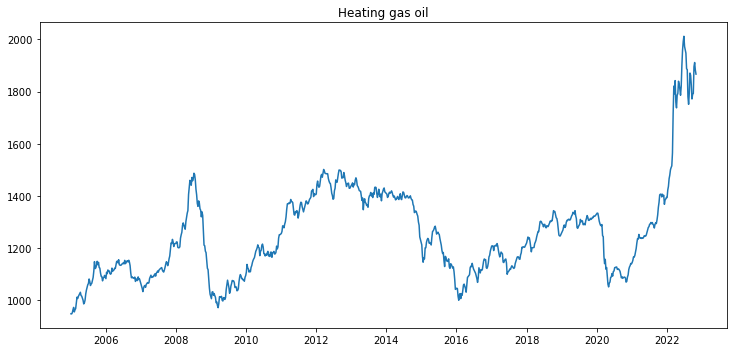

In [148]:
#Analysis of Heating gas oil

#Objective: Analyze the data to see which model fit the best, then pick an appropriate forecasting model
#Plot to show the initial time series of Heating gas oil
y = df_pivot["Heating gas oil"].dropna()

#Plot initial time series
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(y, label='Price')
plt.title("Heating gas oil")
plt.tight_layout()
plt.show()

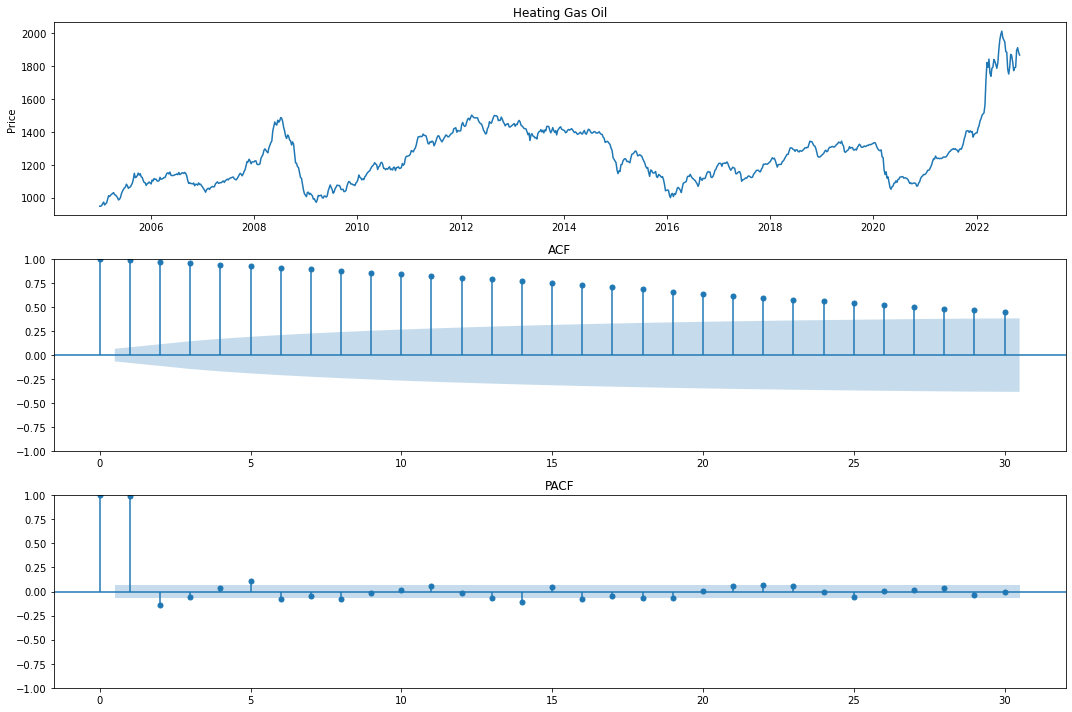

In [149]:
#Analysis of Heating gas oil

#Objective: Analyze the data to see which model fit the best, then pick an appropriate forecasting model
#Plot to show the initial time series of Heating gas oil

# Select the Heating gas oil series
y = df_pivot['Heating gas oil'].dropna()

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Plot the time series
axs[0].plot(y)
axs[0].set_ylabel('Price')
axs[0].set_title('Heating Gas Oil')

# Plot the ACF
sm.graphics.tsa.plot_acf(y, lags=30, ax=axs[1])
axs[1].set_title('ACF')

# Plot the PACF
sm.graphics.tsa.plot_pacf(y, lags=30, ax=axs[2])
axs[2].set_title('PACF')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Optimal value of d: 1
(1, 1, 0)
(0, 0, 0, 12)


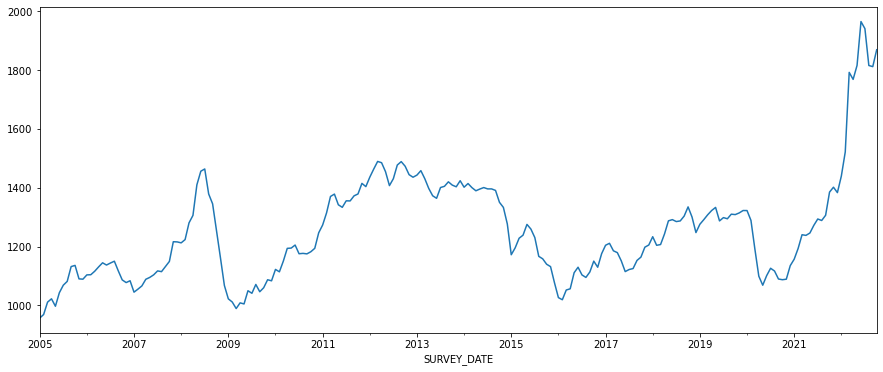

In [150]:
# determine optimal value of d using pmdarima
d = ndiffs(y, test='adf')  # choose ADF test based on p-value
print(f"Optimal value of d: {d}")

# resampling the daily heating gas oil to a monthly frequency and then computing the monthly averages, we can see the overall 
#trend in price over time with less noise and variability than the daily data.
y_month = y.resample('MS').mean() #'MS' stands for beginning of the month, then taking average over the whole month
y_month.plot(figsize = (15, 6))

# use auto_arima to select optimal parameters for SARIMA model (p,d,q)x(P,D,Q,m)
model = auto_arima(y_month, seasonal=True, m=12)

# print selected SARIMA parameters
print(model.order) #(p,d,q)
print(model.seasonal_order) #(P,D,Q,m)

ADF Statistic AIC: -1.2749522208948902
p-value: 0.6405523900559081
ADF Statistic BIC: -0.8825996790688463
p-value: 0.7936485746952217


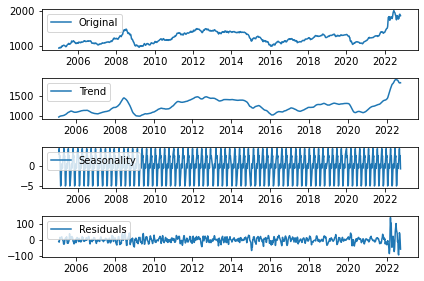

In [151]:
#We see year 2009 - 2020 experience the most upward trend. There is no cyclical pattern to notice.
#This is for sure non-stationary. To ensure our result, we will do a Augmented Dickey-Fuller
#(Unit root test)
#H0: Series is non-stationary; H1: Series is stationary 
# Step 3: Stationarity testing
result = adfuller(y,autolag='AIC')
print(f'ADF Statistic AIC: {result[0]}')
print(f'p-value: {result[1]}')
result3 = adfuller(y,autolag='BIC')
print(f'ADF Statistic BIC: {result3[0]}')
print(f'p-value: {result3[1]}')
#P-value=0.641 which is >0.05, we cannot reject H0. Hence, this is a non-stationary time series.

# Step 4: Time series decomposition
decomposition = seasonal_decompose(y, model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
#fig = decomposition.plot() #if want to have a compress view
plt.tight_layout()
plt.show()


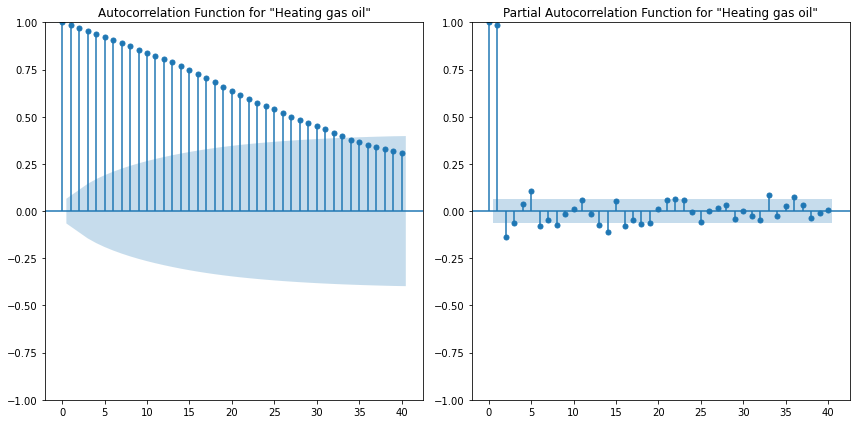

In [152]:
#Analysis of Heating gas oil
#Note: Irregular at 2009, hugh crash. then another crash in 2014, then crash in early 2020, follow by 
#Great increase
#Small upward trend in time span of 2 years.
#Plot to show the initial time series of Heating gas oil
y = df_pivot["Heating gas oil"].dropna()
    
# Calculate ACF and PACF
lag_acf = acf(y, nlags=40), 
lag_pacf = pacf(y, nlags=40, method='ols')

# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(y, lags=40, ax=plt.gca())
plt.title(f'Autocorrelation Function for "Heating gas oil"')

# Plot PACF
plt.subplot(122)
plot_pacf(y, lags=40, ax=plt.gca())
plt.title(f'Partial Autocorrelation Function for "Heating gas oil"')

plt.tight_layout()
plt.show()
#We see the PACF has value drop instantly while ACF has value decreases gradually, hence we are sure to have 
#seasonal component, using ARIMA

In [153]:
# Step 5: Model selection and fitting
# We can select the SARIMA parameters based on the ACF and PACF plots.
# For example, we can set (p, d, q) = (1, 1, 0) and (P, D, Q, m) = (0, 0, 0, ).
# Then, we can fit the SARIMA model to the data and make predictions.

# Define the parameters for the SARIMA model
p = 1  # AR order
d = 1  # I order
q = 0  # MA order
P = 0  # seasonal AR order
D = 0  # seasonal I order
Q = 0  # seasonal MA order
m =12  # seasonal period

# Fit the SARIMA model to the data
model = SARIMAX(y_month, order=(p, d, q), seasonal_order=(P, D, Q, m))
results = model.fit()

# Print the model summary
print(results.summary())

# Step 6: Model evaluation and forecasting
# We can evaluate the model performance on a test set and make predictions for the next 5 years.

# Split the data into training and test sets using 80-20 rules
train_size = int(len(y_month) * 0.8)
train, test = y_month[:train_size], y_month[train_size:]

# Make predictions on the test set
pred = results.predict(start=test.index[0], end=test.index[-1])

# Compute the mean squared error and root mean squared error
mse = mean_squared_error(test, pred)
rmse = mean_squared_error(test, pred, squared=False)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

result = adfuller(y_month,autolag='AIC')
print(f'ADF Statistic AIC: {result[0]}')
print(f'p-value: {result[1]}')
result3 = adfuller(y_month,autolag='BIC')
print(f'ADF Statistic BIC: {result3[0]}')
print(f'p-value: {result3[1]}')

                               SARIMAX Results                                
Dep. Variable:        Heating gas oil   No. Observations:                  214
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1074.318
Date:                Fri, 28 Apr 2023   AIC                           2152.636
Time:                        22:17:45   BIC                           2159.358
Sample:                    01-01-2005   HQIC                          2155.353
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3376      0.035      9.608      0.000       0.269       0.406
sigma2      1406.7945     64.029     21.971      0.000    1281.299    1532.290
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [154]:
if results.arroots.real.max() > 1:
    print("AR polynomial is not invertible")
else:
    print("AR polynomial is invertible")

AR polynomial is not invertible


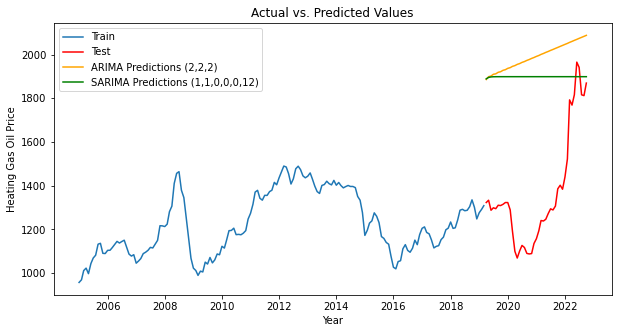

In [161]:
# Plot the actual values, predicted values, and confidence intervals
#Assuming 95% CI
#results is our SARIMA model after fit(.).

#####
#Testing ARIMA model only
ARIMAmodel = SARIMAX(y_month, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out1 = y_pred_df["Predictions"] 

#####
# Start Forecast our data after fiting SARIMA model
y_pred = results.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) #Confidence Interval

#Getting predictions at each confidencer interval
y_pred_df["Predictions"] = results.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out2 = y_pred_df["Predictions"] 

#####
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, color='r', label='Test')
plt.plot(y_pred_out1, color='orange', label = 'ARIMA Predictions (2,2,2)')
plt.plot(y_pred_out2, color='green', label = 'SARIMA Predictions (1,1,0,0,0,12)')
# plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='y', alpha=0.1, label='Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Heating Gas Oil Price')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.savefig('heatgas.png')
plt.show()

